In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
from dateutil.parser import parse
from sklearn.preprocessing import MinMaxScaler

In [98]:
tickers = ['AAPL','MSFT','CSCO','IBM','XOM']
start = '2003-01-01'
end = '2017-01-01'

def prices(tickers,start,end,backend='google'):
    if backend == 'quantopian':
        p = get_pricing(tickers,start,end)
        field = 'price'

    elif backend == 'google':
        p = web.DataReader(tickers, 'google', parse(start), parse(end)).ffill()
        field = 'Close'
        
    scaled = MinMaxScaler((0,1)).fit_transform(p[field])
    pp=pd.DataFrame(scaled,index=p[field].index,columns = tickers)
    return pp

p = prices(tickers,start,end)

In [99]:
def calc_signals(tickers,p,a,b):
    sma = p.rolling(a).mean()
    smb = p.rolling(b).mean()
    signal = np.sign(sma - smb).diff()
    actual_signals = signal[signal!=0].dropna(how='all',axis=0)
    for col in actual_signals.columns:
        idx = actual_signals[col].first_valid_index()
        signal[col][idx] = signal[col][idx]/2

    return signal

sig = calc_signals(tickers,p,40,50)



In [100]:
def calc_pnl(sig,p):
    sig_up = sig.cumsum().apply(lambda x:x*(x>0))
    sig_dwn = sig.cumsum().apply(lambda x:x*(x<0))
    pnl = cumsum(p.pct_change()*sig_up-p.pct_change()*sig_dwn).sum(axis=1)
    return pnl

def calc_sharpe(pnl):
    rets = diff(pnl)/pnl[:-1]
    rets = rets[~isinf(rets)]
    sharpe = np.nanmean(rets)/np.nanstd(rets)*sqrt(252)
    return sharpe
            
def calc_ddwn(pnl):
    hwm = 0
    ddwn = []
    for i in pnl:
        if i>hwm:
            hwm = i
        ddwn.append(i - hwm)
    return min(ddwn)
        
        
#pnl = calc_pnl(sig,p)
#calc_ddwn(pnl)
#print calc_sharpe(sig,p)
#plot(calc_pnl(sig,p))
#show()


In [101]:
# parameter sweep
def parameter_sweep(tickers,p,params,N):
    pnls = []
    sharpes = []
    ddwns = []
    for i in range(N):
        a = min(params[i])
        b = max(params[i])
        try:
            sig = calc_signals(tickers,p,a,b)
            pnl = calc_pnl(sig,p)
            pnls.append(pnl[-1])
            sharpes.append(calc_sharpe(pnl))
            ddwns.append(calc_ddwn(pnl))
        except:
            pnls.append(np.nan)
            sharpes.append(np.nan)
            ddwns.append(np.nan)
            
    return pnls,sharpes,ddwns


In [102]:
# parameter sweep
def parameter_sweep2(tickers,p,params,N):
    pnls = []
    for i in range(N):
        a = min(params[i])
        b = max(params[i])
        try:
            sig = calc_signals(tickers,p,a,b)
            pnls.append(calc_pnl(sig,p))
        except:
            pnls.append(np.nan)
    return pnls

In [103]:

# THIS IS WITH NORMAL TRAIN/TEST PERIOD
N = 3000
sm = 5
lm = 250
frac = 0.5
mid_point = str(timedelta((parse(end)-parse(start)).days*frac)+parse(start))
params = np.array([np.random.randint(sm,lm,(N,)) for i in range(2)]).T
p = prices(tickers,start,mid_point)
pnls1,sharpes1,ddwns1 = parameter_sweep(tickers,p,params,N)
p = prices(tickers,mid_point,end)
pnls2,sharpes2,ddwns2 = parameter_sweep(tickers,p,params,N)


# THIS IS WITH VARIABLE TEST PERIOD

"""N = 5000
sm = 15
lm = 195
params = np.array([np.random.randint(60,90,(N,)) for i in range(2)]).T
p = prices(tickers,start,end)
pnls = parameter_sweep2(tickers,p,params,N)
pnls1 = []
pnls2 = []

frac = 0.2
for pnl in pnls:

    assert(frac<1)
    try:
        a0 = random.randint(0,len(pnl)-round(len(pnl)*frac))
        a1 = int(a0 + round((len(pnl)*frac)))
        pnls1.append(pnl.ix[a0]+pnl.ix[-1])
        pnls2.append(pnl.ix[a1]-pnl.ix[a0])
    except:
        pnls1.append(0)
        pnls2.append(0)"""


In [104]:
def remove_nans(inpts,vals):
    idx = []
    bad_idx = []
    new_inpts = []
    for n,inp in enumerate(inpts):
        for i,j in enumerate(inp):
            if np.isnan(j) or np.isinf(j):
                bad_idx.append(i)
                
    for i in range(len(inpts[0])):
        if not i in bad_idx:
            idx.append(i)
    
    for inp in inpts:
        new_inpts.append(array(inp)[unique(idx)])
        
    new_inpts.append(vals[unique(idx)])
    return new_inpts
print len(pnls1)
            
pnls1,pnls2,sharpes1,sharpes2,ddwns1,ddwns2,params = remove_nans([pnls1,pnls2,sharpes1,sharpes2,ddwns1,ddwns2],params)

3000


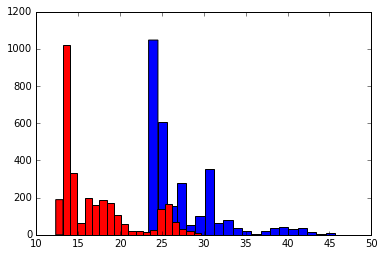

expected shortfall: 0.239556996941


In [105]:
plt.hist(pnls1,20,color='b')
plt.hist(pnls2,20,color='r')
show()
shortfall = ((mean(pnls2)/frac)-mean(pnls1))/mean(pnls1)
print 'expected shortfall:',shortfall

In [106]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import calinski_harabaz_score



def get_cluster_number(X):
    score = 0 
    best_cluster_number = 0 
    for i in range(2,10):
        kmeans = AgglomerativeClustering(n_clusters = i)
        kmeans.fit(X)
        chs = calinski_harabaz_score(X,kmeans.labels_)
        if chs>score:
            best_cluster_number = i 
            score = chs 
    return best_cluster_number

Nc = get_cluster_number(np.array([pnls1,pnls2]).T)
kmeans = KMeans(n_clusters=Nc).fit(np.array([pnls1,pnls2]).T)

In [110]:
plt.scatter(pnls1,pnls2,c=kmeans.labels_,cmap='plasma')

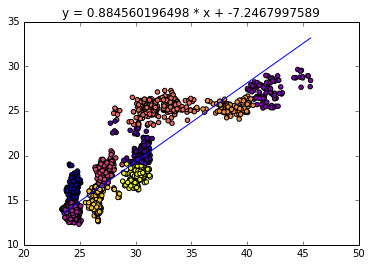

predicted shortfall: 0.115439803502


In [111]:
m = np.polyfit(pnls1,pnls2,1)
xx = np.linspace(min(pnls1),max(pnls1),100)
yy = polyval(m,xx)
plot(xx,yy)
plt.title('y = %s * x + %s'%(m[0],m[1]))
show()
print 'predicted shortfall:',1-m[0]

In [80]:
# Which cluster has the highest OOS pnl?

def find_best_cluster(kmeans):
    median_oos_pnl = []
    for label in np.unique(kmeans.labels_):
        median_pnl = median(pnls2[kmeans.labels_==label])
        median_oos_pnl.append(median_pnl)
    center_mean = argmax(mean(kmeans.cluster_centers_,axis=1))                         
    opt_label = argmax(median_oos_pnl)
    if center_mean!=opt_label:
        print 'Warning: best center mean is different from median oos pnl'
    return opt_label
    
opt_label = find_best_cluster(kmeans)

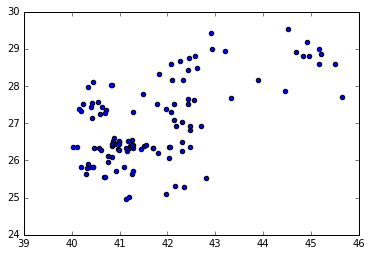

In [81]:
plt.scatter(pnls1[kmeans.labels_==opt_label],pnls2[kmeans.labels_==opt_label])
show()

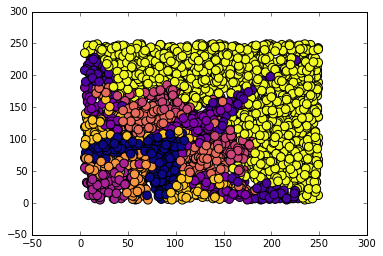

In [82]:
plt.scatter(np.array(params)[:,0],np.array(params)[:,1],c=kmeans.labels_,cmap='plasma',s=75)
show()

In [83]:
best_center = kmeans.cluster_centers_[opt_label]

In [84]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(3)
neigh.fit(np.array([pnls1,pnls2]).T,best_center)
dist,idx = neigh.kneighbors([best_center],15,return_distance=True)

In [85]:


# This is because we sometimes have larger and smaller lkbk reversed but sorted in the pnl calc, and we don't
# want to duplicate this.
unique_params = np.unique(map(sort,params[idx][0]),axis=0)
unique_params

array([[13, 41],
       [14, 40],
       [19, 28],
       [19, 40],
       [20, 27],
       [22, 32],
       [23, 44],
       [24, 34],
       [27, 33],
       [33, 40],
       [33, 48],
       [35, 46],
       [36, 41],
       [37, 43]])

27.290121933 0.568242497456
27.290121933 0.568242497456
27.5222300438 -0.130814371904
27.0780794431 -0.112322858164
27.5212199428 -0.138420293438
27.3719131396 0.728632669853
26.540894827 -0.122554228118
27.0410434973 -0.173621647998
26.9259649037 0.4913497202
26.3442122781 0.419694424676
26.4005366132 0.63654260867
26.368791865 0.621192978706
26.4078730315 -0.281883141294
26.3620067067 0.583901917989


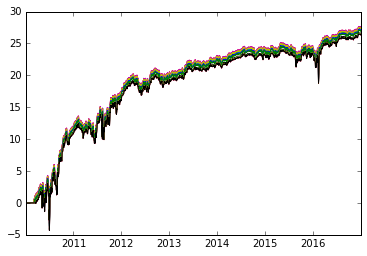

In [86]:
#calc_pnl(calc_signals(tickers,p,unique_params[idx][0][2][0],unique_params[idx][0][2][1]),p)
for par in unique_params:
    print (calc_pnl(calc_signals(tickers,p,par[0],par[1]),p))[-1],
    print (calc_sharpe(calc_pnl(calc_signals(tickers,p,par[0],par[1]),p)))
    plot((calc_pnl(calc_signals(tickers,p,par[0],par[1]),p)))
show()

In [73]:
"""manual_score = []
eject = False
for sharpe,ddwn,pnl in zip(sharpes1,ddwns1,pnls1):
    do_again = True
    if eject: break
    if sharpe > 0 and pnl>30:
        while do_again:
            try:
                print 'shrp:',sharpe,'  ddwn:',ddwn,'  pnl:',pnl
                ip = raw_input()
                if ip == 'stop': 
                    eject = True
                    do_again = False
                manual_score.append(float(ip))
                do_again = False
            except:
                do_again = True
    else:
            manual_score.append(0)"""

"manual_score = []\neject = False\nfor sharpe,ddwn,pnl in zip(sharpes1,ddwns1,pnls1):\n    do_again = True\n    if eject: break\n    if sharpe > 0 and pnl>30:\n        while do_again:\n            try:\n                print 'shrp:',sharpe,'  ddwn:',ddwn,'  pnl:',pnl\n                ip = raw_input()\n                if ip == 'stop': \n                    eject = True\n                    do_again = False\n                manual_score.append(float(ip))\n                do_again = False\n            except:\n                do_again = True\n    else:\n            manual_score.append(0)"